In [99]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm.notebook import tqdm
from absl import flags

## Relative imports
from dataHandler.dataset import MHDProjDataset,LogNormalTransform

from ddpm.model import UNet, ResUNet
from ddpm.diffusion import DDPM, generate_image, NCSN

from validationMetrics.powerSpectrum import power_spectrum_iso, plot_ps, compare_separation_power_spectrum_iso, plot_set_power_spectrum_iso
from validationMetrics.minkowskiFunctional import plot_mink_functionals

from separation import double_loader, method1_algo2
from scipy.signal import savgol_filter
from utils.gaussian_random_field import compute_autocovariance, gaussian_random_field, generate_grf

In [152]:
MODEL_ID1 = 'MHD_DDPM_skip_GN_bottleneck16_diffusion10000_beta1e-4_dens'

CKPT_FOLDER1 = '/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps'

MODEL_ID2 = 'GRFSAME_DDPM_skip_GN_bottleneck32_diffusion10000'

CKPT_FOLDER2 = '/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps'

NUM_SAMPLES = 32

In [153]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [154]:
FLAGS1=flags.FLAGS

In [155]:
for name in list(flags.FLAGS):
  delattr(flags.FLAGS, name)

In [156]:
try:
    flags.DEFINE_string('model_id','MHD_DDPM_forget',help= 'ID of the model either trained, finetuned, evaluated....')

    ## Data & transforms
    flags.DEFINE_string('source_dir','/mnt/home/dheurtel/ceph/00_exploration_data/density/b_proj',help= 'Source dir containing a list of npy files')
    flags.DEFINE_bool('random_rotate', True, help='')
    flags.DEFINE_bool('no_lognorm', False, help='apply a lognormal transformation to the dataset')

    ## Network & diffusion parameters

    flags.DEFINE_enum('diffusion_mode', 'ddpm', ['ddpm', 'smld', 'VE', 'VD', 'sub_VP'], help='Type of diffusion SDE used during training and inference')
    ## TODO if we want to fully use the SDE/ score based framework (and have custom/off the shelf SDE solvers, we will nedd to use runners/differentiate the training loop)
    # For DDPM
    flags.DEFINE_integer('n_steps', 1000, help= 'Diffusion total time see Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')
    flags.DEFINE_float('beta_start', 1e-4, help = 'Beta at time 0 see Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')
    flags.DEFINE_float('beta_T',0.02, help= 'Beta at time T=n_steps Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')

    #Unet
    flags.DEFINE_enum('network', 'unet', ['unet', 'ResUNet'], help='DUNet not yet implemented')
    flags.DEFINE_integer('size',256, help='height and width of the images')
    flags.DEFINE_integer('in_channel', 1, help= 'number of channel on input and output images')
    flags.DEFINE_enum('normalization', 'LN' , ['LN' , 'default', 'LN-D', 'LN-F', 'LN-F+', 'LN-DF', 'BN', 'BN/LN', 'BN/FLN', 'BN/F+LN', 'DBN/LN', 'GN', 'DN','None'], help= 'type of normalization applied') ## TODO upcoming cleaning of these options based on elimination and perceived redundancies
    flags.DEFINE_float('eps_norm', 1e-5, help= 'epsilon value added to the variance in the normalization layer to ensure numerical stability')
    flags.DEFINE_integer('size_min', 32, help= 'size at the bottleneck')
    flags.DEFINE_integer('num_blocks', 1, help= 'num of blocks per size on descent')
    flags.DEFINE_enum('padding_mode', 'circular' ,['zeros', 'reflect', 'replicate','circular'], help='Conv2d padding mode')
    flags.DEFINE_bool('muP', False, help= 'Use mu Parametrisation for initialisation and training') ## TODO 
    flags.DEFINE_float('dropout', 0, help= 'Probability for dropout, we did not find any impact because our models tend not to overfit')
    flags.DEFINE_integer('first_c_mult', 10, help= 'Multiplier between in_c and out_c for the first block')
    flags.DEFINE_bool('skip_rescale', False, help='Rescale skip connections (see Score Based Generative Modelling paper)')

    ## Training parameters 
    flags.DEFINE_integer('batch_size', 64, help='Dataloader batch size')
    flags.DEFINE_integer('num_sample', 8, help='Number of sample for an epoch in the middle')
    flags.DEFINE_integer('num_result_sample', 256, help='Number of sample for an epoch in the middle')
    flags.DEFINE_float('lr', 1e-3, help= 'Learning rate')
    flags.DEFINE_enum('lr_scheduler', 'None', ['None','stepLR'], help='scheduler, if any used in training')
    flags.DEFINE_integer('warmup', 100, help='Length of warmup, if 0 then no warmup')
    flags.DEFINE_integer('test_set_len', 95, help='')
    flags.DEFINE_integer('num_epochs', 500, help='Number of epochs')
    flags.DEFINE_enum('optimizer', 'Adam', ['AdamW', 'Adam', 'MoMo'], help='MoMo not implemented in particular for now') ## TODO MoMo 
    flags.DEFINE_float('weight_decay', 0.0, help= 'Weight decay hyper parameter')
    flags.DEFINE_float('ema', 0.0, help='Exponentially moving average momentum, if 0 then no ema applied NOT IMPLEMENTED yet ')  ## TODO

    ## Sampling and checkpointing
    flags.DEFINE_integer('save_step_epoch', 100, help='Period in nb of epochs for saving ckpt & losses')
    flags.DEFINE_integer('sample_step_epoch', 100, help='Period in nb of epoch for generating a few npy samples')
    flags.DEFINE_string('sample_folder','/mnt/home/dheurtel/ceph/20_samples/artificial_architecture_exps',help= 'directory where generated samples (in the middle of training) or results are stored')
    flags.DEFINE_string('ckpt_folder','/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps',help= 'Directory for ckpt & loss storage (as well as some training specs)')
except:
    print("Flags already defined but you can still re-parse them with next few cells")

In [157]:
def extract_flag_name(str):
    pref='--'
    suff='='
    try:
        idx1 = str.index(pref)
        idx2 = str.index(suff)
    except:
        try:
            idx1 = str.index(pref)
            idx2=len(str)
        except:
            return None
    return str[idx1 + len(pref): idx2]

In [158]:
with open(os.path.join(CKPT_FOLDER1, MODEL_ID1, 'flagfile.txt')) as f:
    lines = f.read().splitlines()

lines=[s for s in lines if extract_flag_name(s) in FLAGS1]

FLAGS1(lines)

['--batch_size=64']

In [159]:
if FLAGS1.network == "unet":
    log2sizes = list(
        range(int(np.log2(FLAGS1.size_min)), int(np.log2(FLAGS1.size)) + 1)
    )[::-1]
    sizes = [2**i for i in log2sizes]

    network1 = UNet(
        in_c=FLAGS1.in_channel,
        out_c=FLAGS1.in_channel,
        first_c=FLAGS1.first_c_mult * FLAGS1.in_channel,
        sizes=sizes,
        num_blocks=1,
        n_steps=FLAGS1.n_steps,
        time_emb_dim=100,
        dropout=FLAGS1.dropout,
        attention=[],
        normalisation=FLAGS1.normalization,
        padding_mode=FLAGS1.padding_mode,
        eps_norm=FLAGS1.eps_norm,
    )
    network1 = network1.to(device)
if FLAGS1.network == "ResUNet":
    log2sizes = list(
        range(int(np.log2(FLAGS1.size_min)), int(np.log2(FLAGS1.size)) + 1)
    )[::-1]
    sizes = [2**i for i in log2sizes]

    network1 = ResUNet(
        in_c=FLAGS1.in_channel,
        out_c=FLAGS1.in_channel,
        first_c=FLAGS1.first_c_mult * FLAGS1.in_channel,
        sizes=sizes,
        num_blocks=1,
        n_steps=FLAGS1.n_steps,
        time_emb_dim=100,
        dropout=FLAGS1.dropout,
        attention=[],
        normalisation=FLAGS1.normalization,
        padding_mode=FLAGS1.padding_mode,
        eps_norm=FLAGS1.eps_norm,
        skiprescale=FLAGS1.skip_rescale,
    )
    network1 = network1.to(device)
beta_T=FLAGS1.beta_T*1000/FLAGS1.n_steps
if FLAGS1.diffusion_mode == "ddpm":
    model1 = DDPM(
        network1,
        FLAGS1.n_steps,
        beta_start=FLAGS1.beta_start,
        beta_end=beta_T,
        device=device,
    )
elif FLAGS1.diffusion_mode == "smld":
    model1 = NCSN(
        network1,
        FLAGS1.n_steps,
        beta_start=FLAGS1.beta_start,
        beta_end=beta_T,
        device=device,
    )

In [160]:
ckpt1 = torch.load(os.path.join(CKPT_FOLDER1, MODEL_ID1, 'ckpt.pt'),map_location=torch.device('cpu'))

In [161]:
file_list1=ckpt1['test_set']
np.random.shuffle(file_list1)
model1.load_state_dict(ckpt1['ddpm_model'])

<All keys matched successfully>

In [162]:
SOURCE_DIR1=FLAGS1.source_dir

SAMPLE_FOLDER1=FLAGS1.sample_folder

if FLAGS1.no_lognorm:
    transforms1 = None
else:
    transforms1 = LogNormalTransform()  

In [163]:
SIZE=FLAGS1.size

N_STEPS=FLAGS1.n_steps

In [164]:
dataset1=MHDProjDataset(SOURCE_DIR1,random_rotate=FLAGS1.random_rotate,transforms=transforms1,test_batch_length=FLAGS1.test_set_len, test_file_list=file_list1)

test_batch1=dataset1.test_batch()

In [165]:
for name in list(flags.FLAGS):
  delattr(flags.FLAGS, name)

In [166]:
FLAGS2=flags.FLAGS
try:
    flags.DEFINE_string('model_id','MHD_DDPM_forget',help= 'ID of the model either trained, finetuned, evaluated....')

    ## Data & transforms
    flags.DEFINE_string('source_dir','/mnt/home/dheurtel/ceph/00_exploration_data/density/b_proj',help= 'Source dir containing a list of npy files')
    flags.DEFINE_bool('random_rotate', True, help='')
    flags.DEFINE_bool('no_lognorm', False, help='apply a lognormal transformation to the dataset')

    ## Network & diffusion parameters

    flags.DEFINE_enum('diffusion_mode', 'ddpm', ['ddpm', 'smld', 'VE', 'VD', 'sub_VP'], help='Type of diffusion SDE used during training and inference')
    ## TODO if we want to fully use the SDE/ score based framework (and have custom/off the shelf SDE solvers, we will nedd to use runners/differentiate the training loop)
    # For DDPM
    flags.DEFINE_integer('n_steps', 1000, help= 'Diffusion total time see Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')
    flags.DEFINE_float('beta_start', 1e-4, help = 'Beta at time 0 see Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')
    flags.DEFINE_float('beta_T',0.02, help= 'Beta at time T=n_steps Ho, J., Jain, A., & Abbeel, P. (2020). Denoising diffusion probabilistic models')

    #Unet
    flags.DEFINE_enum('network', 'unet', ['unet', 'ResUNet'], help='DUNet not yet implemented')
    flags.DEFINE_integer('size',256, help='height and width of the images')
    flags.DEFINE_integer('in_channel', 1, help= 'number of channel on input and output images')
    flags.DEFINE_enum('normalization', 'LN' , ['LN' , 'default', 'LN-D', 'LN-F', 'LN-F+', 'LN-DF', 'BN', 'BN/LN', 'BN/FLN', 'BN/F+LN', 'DBN/LN', 'GN', 'DN','None'], help= 'type of normalization applied') ## TODO upcoming cleaning of these options based on elimination and perceived redundancies
    flags.DEFINE_float('eps_norm', 1e-5, help= 'epsilon value added to the variance in the normalization layer to ensure numerical stability')
    flags.DEFINE_integer('size_min', 32, help= 'size at the bottleneck')
    flags.DEFINE_integer('num_blocks', 1, help= 'num of blocks per size on descent')
    flags.DEFINE_enum('padding_mode', 'circular' ,['zeros', 'reflect', 'replicate','circular'], help='Conv2d padding mode')
    flags.DEFINE_bool('muP', False, help= 'Use mu Parametrisation for initialisation and training') ## TODO 
    flags.DEFINE_float('dropout', 0, help= 'Probability for dropout, we did not find any impact because our models tend not to overfit')
    flags.DEFINE_integer('first_c_mult', 10, help= 'Multiplier between in_c and out_c for the first block')
    flags.DEFINE_bool('skip_rescale', False, help='Rescale skip connections (see Score Based Generative Modelling paper)')

    ## Training parameters 
    flags.DEFINE_integer('batch_size', 64, help='Dataloader batch size')
    flags.DEFINE_integer('num_sample', 8, help='Number of sample for an epoch in the middle')
    flags.DEFINE_integer('num_result_sample', 256, help='Number of sample for an epoch in the middle')
    flags.DEFINE_float('lr', 1e-3, help= 'Learning rate')
    flags.DEFINE_enum('lr_scheduler', 'None', ['None','stepLR'], help='scheduler, if any used in training')
    flags.DEFINE_integer('warmup', 100, help='Length of warmup, if 0 then no warmup')
    flags.DEFINE_integer('test_set_len', 95, help='')
    flags.DEFINE_integer('num_epochs', 500, help='Number of epochs')
    flags.DEFINE_enum('optimizer', 'Adam', ['AdamW', 'Adam', 'MoMo'], help='MoMo not implemented in particular for now') ## TODO MoMo 
    flags.DEFINE_float('weight_decay', 0.0, help= 'Weight decay hyper parameter')
    flags.DEFINE_float('ema', 0.0, help='Exponentially moving average momentum, if 0 then no ema applied NOT IMPLEMENTED yet ')  ## TODO

    ## Sampling and checkpointing
    flags.DEFINE_integer('save_step_epoch', 100, help='Period in nb of epochs for saving ckpt & losses')
    flags.DEFINE_integer('sample_step_epoch', 100, help='Period in nb of epoch for generating a few npy samples')
    flags.DEFINE_string('sample_folder','/mnt/home/dheurtel/ceph/20_samples/artificial_architecture_exps',help= 'directory where generated samples (in the middle of training) or results are stored')
    flags.DEFINE_string('ckpt_folder','/mnt/home/dheurtel/ceph/10_checkpoints/artificial_architecture_exps',help= 'Directory for ckpt & loss storage (as well as some training specs)')
except:
    print("Flags already defined but you can still re-parse them with next few cells")

In [167]:
with open(os.path.join(CKPT_FOLDER2, MODEL_ID2, 'flagfile.txt')) as f:
    lines = f.read().splitlines()

lines=[s for s in lines if extract_flag_name(s) in FLAGS2]

FLAGS2(lines)

['--batch_size=64']

In [168]:
if FLAGS2.network == "unet":
    log2sizes = list(
        range(int(np.log2(FLAGS2.size_min)), int(np.log2(FLAGS2.size)) + 1)
    )[::-1]
    sizes = [2**i for i in log2sizes]

    network2 = UNet(
        in_c=FLAGS2.in_channel,
        out_c=FLAGS2.in_channel,
        first_c=FLAGS2.first_c_mult * FLAGS2.in_channel,
        sizes=sizes,
        num_blocks=1,
        n_steps=FLAGS2.n_steps,
        time_emb_dim=100,
        dropout=FLAGS2.dropout,
        attention=[],
        normalisation=FLAGS2.normalization,
        padding_mode=FLAGS2.padding_mode,
        eps_norm=FLAGS2.eps_norm,
    )
    network2 = network2.to(device)
if FLAGS2.network == "ResUNet":
    log2sizes = list(
        range(int(np.log2(FLAGS2.size_min)), int(np.log2(FLAGS2.size)) + 1)
    )[::-1]
    sizes = [2**i for i in log2sizes]

    network2 = ResUNet(
        in_c=FLAGS2.in_channel,
        out_c=FLAGS2.in_channel,
        first_c=FLAGS2.first_c_mult * FLAGS2.in_channel,
        sizes=sizes,
        num_blocks=1,
        n_steps=FLAGS2.n_steps,
        time_emb_dim=100,
        dropout=FLAGS2.dropout,
        attention=[],
        normalisation=FLAGS2.normalization,
        padding_mode=FLAGS2.padding_mode,
        eps_norm=FLAGS2.eps_norm,
        skiprescale=FLAGS2.skip_rescale,
    )
    network2 = network2.to(device)
beta_T=FLAGS2.beta_T*1000/FLAGS2.n_steps
if FLAGS2.diffusion_mode == "ddpm":
    model2 = DDPM(
        network2,
        FLAGS2.n_steps,
        beta_start=FLAGS2.beta_start,
        beta_end=beta_T,
        device=device,
    )
elif FLAGS2.diffusion_mode == "smld":
    model2 = NCSN(
        network2,
        FLAGS2.n_steps,
        beta_start=FLAGS2.beta_start,
        beta_end=beta_T,
        device=device,
    )

In [169]:
ckpt2 = torch.load(os.path.join(CKPT_FOLDER2, MODEL_ID2, 'ckpt.pt'),map_location=torch.device('cpu'))

In [170]:
file_list2=ckpt2['test_set']
np.random.shuffle(file_list2)
model2.load_state_dict(ckpt2['ddpm_model'])

<All keys matched successfully>

In [171]:
SOURCE_DIR2=FLAGS2.source_dir

SAMPLE_FOLDER2=FLAGS2.sample_folder

if FLAGS2.no_lognorm:
    transforms2 = None
else:
    transforms2 = LogNormalTransform()  

In [172]:
dataset2=MHDProjDataset(SOURCE_DIR2,random_rotate=FLAGS2.random_rotate,transforms=transforms2,test_batch_length=FLAGS2.test_set_len, test_file_list=file_list2)

test_batch2=dataset2.test_batch()

In [173]:
## For plots and summary statistics
amin,amax=(-6.232629, 7.390278)
bins = np.linspace(0, np.pi, 100)

## Stability
eps = 1e-1

## Changing dataset2
SCALING_FACTOR = 1
EXACT_SCORE = True

Compute auto-covariance for gaussian random fields and then modify or not the dataset2 (corresponding to the gaussian random field) if EXACT_SCORE

In [174]:
## Compute the needed covariance
cov_mean_=np.zeros((256,256))
n=len(dataset2)
for data_point in dataset2:
    cov_mean_+=compute_autocovariance(SCALING_FACTOR*data_point)/n
cov_mean = torch.from_numpy(cov_mean_).to(device).type(torch.float32)
delta=torch.ones(256, 256, dtype=torch.float32).to(device)

In [76]:
alternative_test_batch2 = []
if EXACT_SCORE:
    for i in range(len(test_batch2)):
        alternative_test_batch2.append(generate_grf(cov_mean_).reshape(1, 1, 256, 256).astype(np.float32))
    test_batch2_copy = test_batch2
    test_batch2 = torch.from_numpy(np.concatenate(alternative_test_batch2))


In [77]:
if not(EXACT_SCORE):
    test_batch2*=SCALING_FACTOR 

In [78]:
lmin = min(len(test_batch1), len(test_batch2))
superposition = test_batch1[:lmin]+test_batch2[:lmin]
superposition = superposition.to(device)

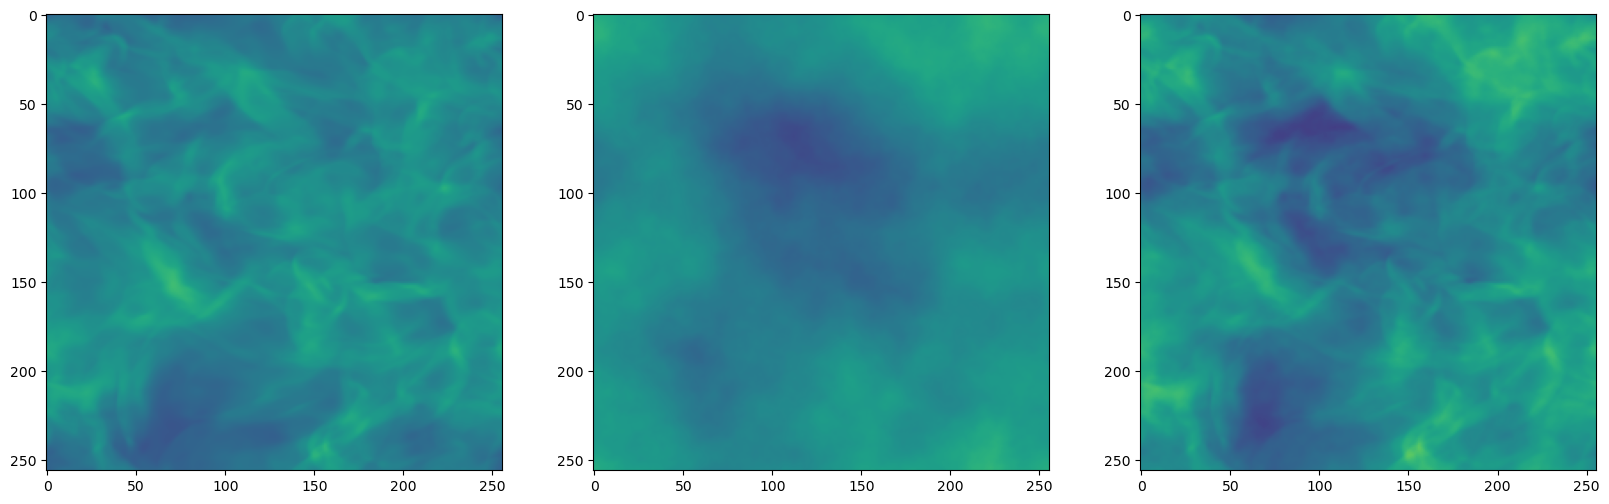

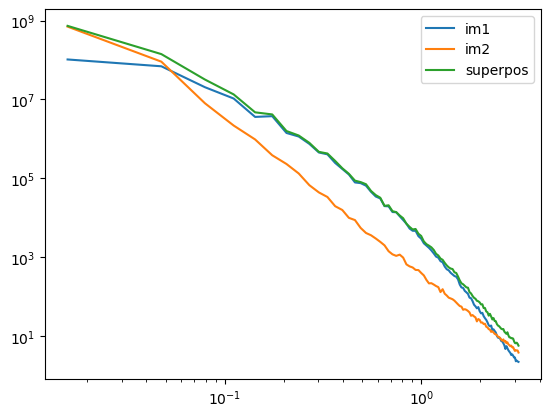

In [79]:
fig, ax= plt.subplots(1,3,figsize=(20,8))
ax[0].imshow(test_batch1[0][0],vmin=amin, vmax=amax)
ax[1].imshow(test_batch2[0][0],vmin=amin, vmax=amax)
ax[2].imshow(superposition.cpu()[0][0],vmin=amin, vmax=amax)
plt.show()
_, b1, _ = power_spectrum_iso(test_batch1[0][0],bins=bins)
_, b2, _ = power_spectrum_iso(test_batch2[0][0],bins=bins)
_, b3, _ = power_spectrum_iso(superposition[0][0].cpu(),bins=bins)
plot_ps(bins, [b1, b2, b3], ['im1', 'im2', 'superpos'], show = True)

## DDRM 

In [80]:
H = torch.cat([torch.eye(256,256),torch.eye(256,256)], axis = 1)
H_plus = torch.linalg.pinv(H)
U, S, Vh = torch.linalg.svd(H)

In [81]:
U.max(), U.min(), S.max(), S.min(), Vh.max(), Vh.min()

(tensor(1.),
 tensor(-1.),
 tensor(1.4142),
 tensor(1.4142),
 tensor(0.7071),
 tensor(-0.7071))

In [82]:
U[-1, -1] = 1

Vh[255, 511] = 1/np.sqrt(2)

Vh[255, 255] = 1/np.sqrt(2)

(H - U@torch.cat((torch.diag_embed(S), torch.zeros(256,256)), axis = 1)@Vh).mean()

tensor(3.4970e-10)

In [83]:
H_plus.dtype

torch.float32

In [84]:
modified_obs = torch.einsum('ij,bcjk->bcik',H_plus.to(device),superposition)
partial_proj = (- H_plus@H).to(device)

In [85]:
schedule = list(range(0,100))+list(range(100,1000,2))+list(range(1000,2000,5))+list(range(1000, 10000, 10))
schedule = list(range(0, 10000, 2))

In [86]:
hyper = 1
eta = 0.1

In [87]:
def ddrm_ddim(model1, model2,schedule,num_to_separate = 1, sample_size= 16, observation = superposition, eta = 1, hyper = 1, exact_score = False, covariance = cov_mean, H = H):
    model1.eval()
    ## TODO change here
    partial_observation = observation[:num_to_separate]
    observation_repeated = partial_observation.repeat(sample_size, 1, 1, 1)
    
    H_plus = torch.linalg.pinv(H)

    modified_obs = torch.einsum('ij,bcjk->bcik',H_plus.to(device),observation_repeated)
    partial_proj = (- H_plus@H).to(device)

    ps_0 = torch.fft.fft2(covariance)

    with torch.no_grad():
        timesteps = schedule[::-1]
        sample1 = torch.randn_like(observation_repeated).to(device)
        sample2 = torch.randn_like(observation_repeated).to(device)
        progress_bar = tqdm(total=len(schedule))
        for i, t in enumerate(timesteps):
            time_tensor = (torch.ones(sample_size, 1) * t).long().to(device)

            residual1 = model1.reverse(sample1, time_tensor)
            
            if exact_score:
                ps = (model1.sqrt_alphas_cumprod[t]**2 * ps_0 + model1.sqrt_one_minus_alphas_cumprod[t]**2 * delta).real
                mod_ps = ps 
                residual2 = model1.sqrt_one_minus_alphas_cumprod[t]*( torch.fft.ifft2(1/(mod_ps)*torch.fft.fft2(sample2))).real
            else:
                residual2 = model2.reverse(sample2, time_tensor)

            sq_a_t_1 = (model1.sqrt_alphas_cumprod[timesteps[i + 1]] if t > 0 else 1)
            sq_1_min_a_t_1 = (model1.sqrt_one_minus_alphas_cumprod[timesteps[i + 1]] if t > 0 else 0)
            sq_a_t = model1.sqrt_alphas_cumprod[t]
            sq_1_min_a_t = (model1.sqrt_one_minus_alphas_cumprod[t])

            sample_hat_1= 1/sq_a_t* (sample1 - sq_1_min_a_t * residual1)
            sample_hat_2= 1/sq_a_t* (sample2 - sq_1_min_a_t * residual2)

            intermediar = torch.cat([sample_hat_1, sample_hat_2], axis = 2)

            intermediar_tilde = modified_obs + torch.einsum('ij,bcjk->bcik',partial_proj,intermediar)
            sample_tilde_1,sample_tilde_2 = intermediar_tilde[:,:,:256,:],intermediar_tilde[:,:,256:,:]



            #residual1, residual2 = torch.randn_like(residual1),torch.randn_like(residual2)
            #sample_tilde_1, sample_tilde_2 = residual1, residual2
            sample1 = sq_a_t_1 * (sample_hat_1 +  eta * sq_1_min_a_t * sample_tilde_1) + hyper * sq_1_min_a_t_1 * residual1
            sample2 = sq_a_t_1 * (sample_hat_2 +  eta * sq_1_min_a_t * sample_tilde_2) + hyper * sq_1_min_a_t_1 * residual2
            progress_bar.update(1)
        progress_bar.close()
    model1.train()
    return sample1, sample2

In [88]:
eps = 1e-5

In [89]:
compute_autocovariance(torch.randn(256,256))

array([[ 1.00195052e+00,  3.39307895e-03, -2.85327546e-03, ...,
        -5.31311484e-03, -2.85327546e-03,  3.39307895e-03],
       [-6.23122595e-03,  5.50663434e-03,  5.15559823e-04, ...,
        -2.52263945e-03, -2.70100586e-03, -2.98556403e-03],
       [ 6.83508486e-03, -1.16518289e-03, -4.60718085e-03, ...,
        -4.67247914e-04,  2.76978669e-03, -2.90695802e-03],
       ...,
       [-1.93832224e-03,  2.69987887e-03,  2.18122575e-04, ...,
         2.29560465e-03, -1.96867355e-03,  3.85956689e-03],
       [ 6.83508486e-03, -2.90695802e-03,  2.76978669e-03, ...,
        -4.57664895e-03, -4.60718085e-03, -1.16518289e-03],
       [-6.23122595e-03, -2.98556403e-03, -2.70100586e-03, ...,
         1.32288725e-03,  5.15559823e-04,  5.50663434e-03]])

In [90]:
ps = torch.fft.fft2(torch.cat([torch.from_numpy(compute_autocovariance(torch.randn(256,256))).unsqueeze(0) for idx in range(1000)]).mean(dim = 0)).real

In [160]:
test = superposition[:1].repeat(8, 1, 1, 1)
model1.eval()
model2.eval()
with torch.no_grad():
    tot_steps=model1.num_timesteps
    timesteps=list(range(tot_steps))[::-1]
    sample1=torch.randn(test.shape).to(device)
    sample2=torch.randn(test.shape).to(device)

    progress_bar = tqdm(total=tot_steps)

    for t in timesteps:
        time_tensor = (torch.ones(test.shape[0], 1)* t).long().to(device)
        residual1 = model1.reverse(sample1, time_tensor)
        residual2 = model2.reverse(sample2, time_tensor)
        #ps = (model1.sqrt_alphas_cumprod[t]**2*torch.fft.fft2(cov_mean)+model1.sqrt_one_minus_alphas_cumprod[t]**2*delta).real
        #mod_ps = ps + eps * (mod_ps < ps)
        #residual2 = model1.sqrt_one_minus_alphas_cumprod[t]*(torch.fft.ifft2(1/(mod_ps)*torch.fft.fft2(sample2))).real

        coef_epsilon = (1 - model1.alphas)[t] / model1.sqrt_one_minus_alphas_cumprod[t]
        coef_first = 1 / model1.alphas[t]**0.5

        noise1 = torch.randn_like(residual1)
        noise2 = torch.randn_like(residual2)
        
        if t > 0:
            variance = (model1.betas[t] ** 0.5) 
        else:
            variance = 0

        sample1 = coef_first * (sample1 - coef_epsilon * residual1) + variance * noise1
        sample2 = coef_first * (sample2 - coef_epsilon * residual2) + variance * noise2
        progress_bar.update(1)

NameError: name 'superpos_test' is not defined

In [91]:
sample1, sample2 = ddrm_ddim(model1, model2, schedule, observation=superposition, sample_size= 16, eta=0.1, exact_score=EXACT_SCORE, covariance=cov_mean, H = H)

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Method 2')

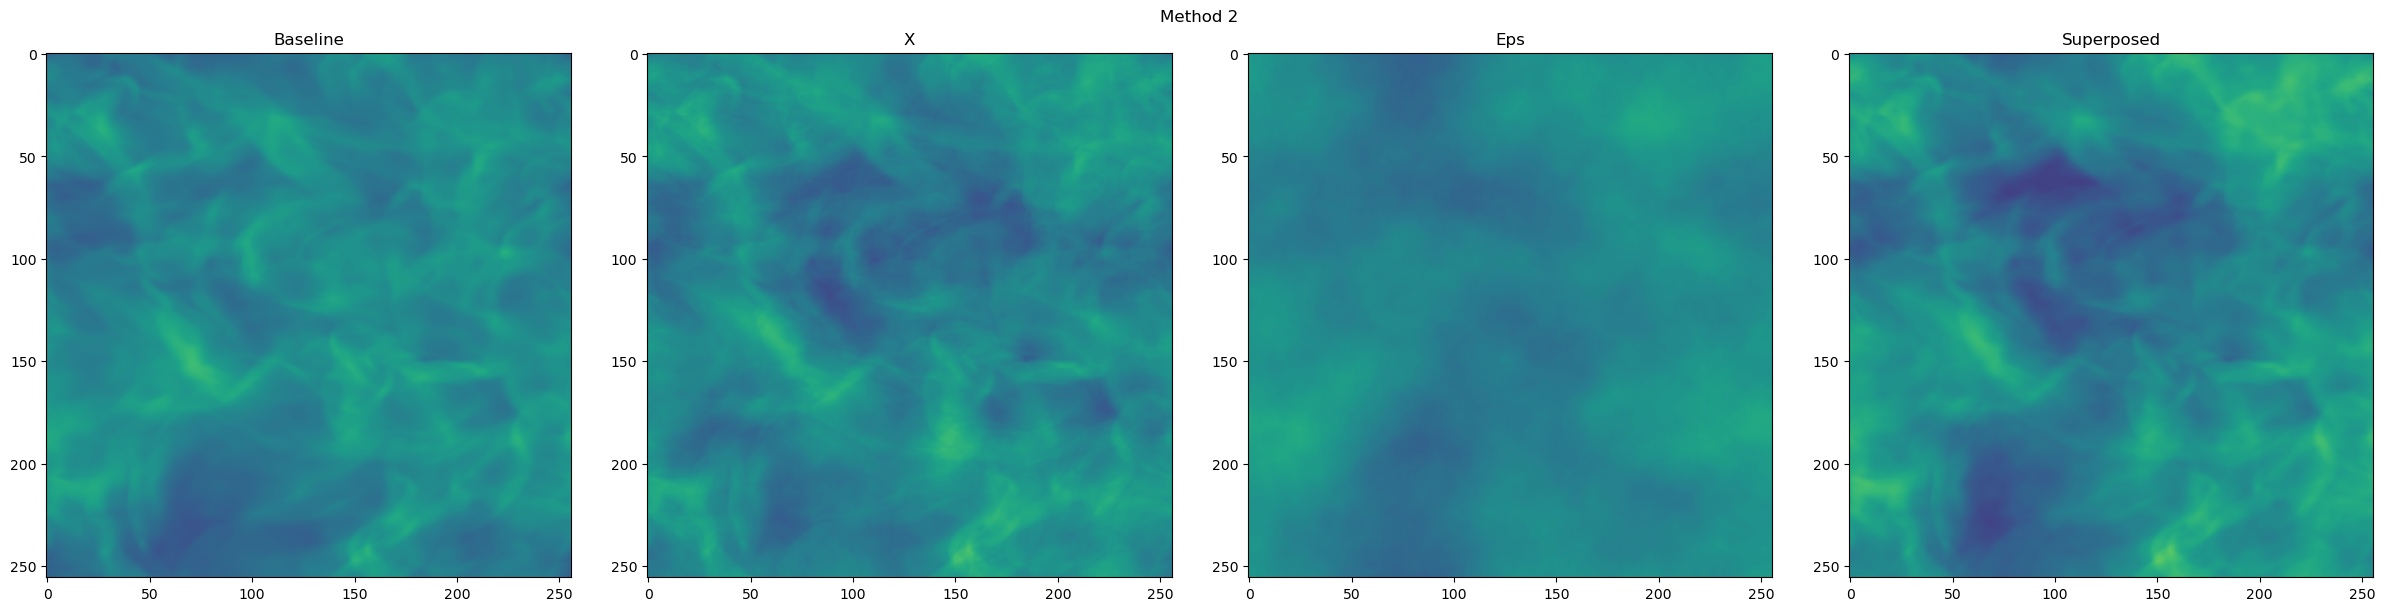

In [93]:
fig, ax= plt.subplots(1,4,figsize=(24,6), layout= 'constrained')
ax[0].imshow(test_batch1[0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Baseline')

ax[1].imshow(sample1[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('X')

ax[2].imshow(sample2[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[2].title.set_text('Eps')

ax[3].imshow(superposition[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[3].title.set_text('Superposed')

fig.suptitle('Method 2')

In [94]:
(superposition[:1].repeat(16,1,1,1)-(sample1+sample2)).std()

tensor(0.0551, device='cuda:0')

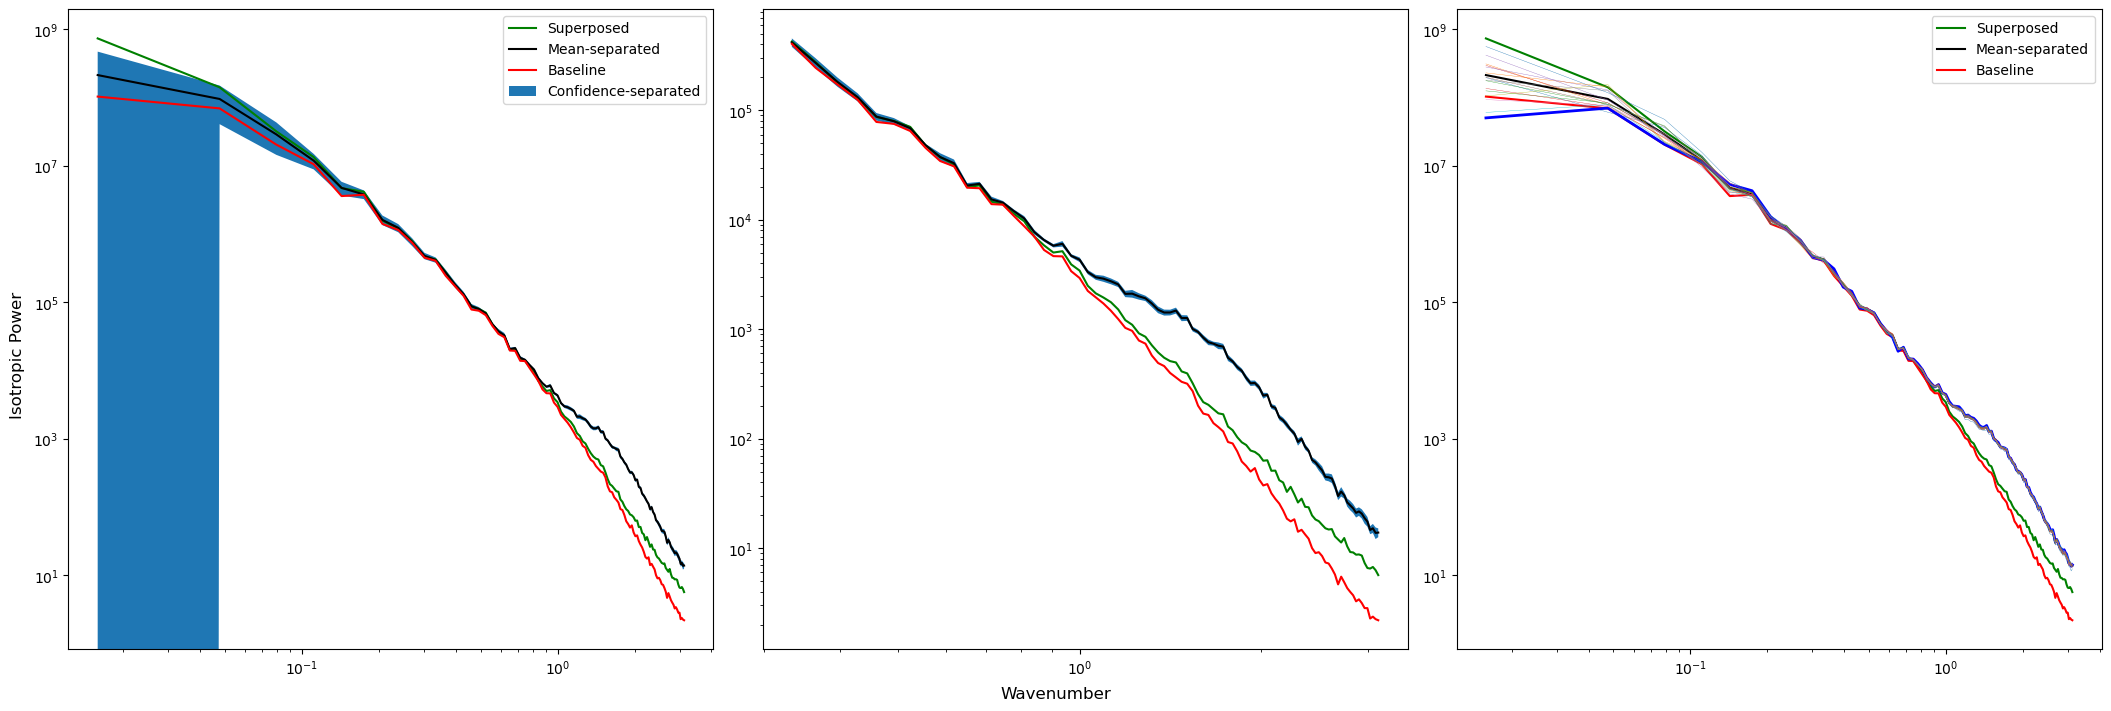

In [95]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(test_batch1,sample1, noisy=superposition)

In [ ]:
def efficient_generalized_steps(x, seq, model, b, H_funcs, y_0, sigma_0, etaB, etaA, etaC, cls_fn=None, classes=None):
    with torch.no_grad():
        #setup vectors used in the algorithm
        singulars = H_funcs.singulars()
        Sigma = torch.zeros(x.shape[1]*x.shape[2]*x.shape[3], device=x.device)
        Sigma[:singulars.shape[0]] = singulars
        U_t_y = H_funcs.Ut(y_0)
        Sig_inv_U_t_y = U_t_y / singulars[:U_t_y.shape[-1]]

        #initialize x_T as given in the paper
        largest_alphas = compute_alpha(b, (torch.ones(x.size(0)) * seq[-1]).to(x.device).long())
        largest_sigmas = (1 - largest_alphas).sqrt() / largest_alphas.sqrt()
        large_singulars_index = torch.where(singulars * largest_sigmas[0, 0, 0, 0] > sigma_0)
        inv_singulars_and_zero = torch.zeros(x.shape[1] * x.shape[2] * x.shape[3]).to(singulars.device)
        inv_singulars_and_zero[large_singulars_index] = sigma_0 / singulars[large_singulars_index]
        inv_singulars_and_zero = inv_singulars_and_zero.view(1, -1)     

        # implement p(x_T | x_0, y) as given in the paper
        # if eigenvalue is too small, we just treat it as zero (only for init) 
        init_y = torch.zeros(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]).to(x.device)
        init_y[:, large_singulars_index[0]] = U_t_y[:, large_singulars_index[0]] / singulars[large_singulars_index].view(1, -1)
        init_y = init_y.view(*x.size())
        remaining_s = largest_sigmas.view(-1, 1) ** 2 - inv_singulars_and_zero ** 2
        remaining_s = remaining_s.view(x.shape[0], x.shape[1], x.shape[2], x.shape[3]).clamp_min(0.0).sqrt()
        init_y = init_y + remaining_s * x
        init_y = init_y / largest_sigmas
        
        #setup iteration variables
        x = H_funcs.V(init_y.view(x.size(0), -1)).view(*x.size())
        n = x.size(0)
        seq_next = [-1] + list(seq[:-1])
        x0_preds = []
        xs = [x]

        #iterate over the timesteps
        for i, j in tqdm(zip(reversed(seq), reversed(seq_next))):
            t = (torch.ones(n) * i).to(x.device)
            next_t = (torch.ones(n) * j).to(x.device)
            at = compute_alpha(b, t.long())
            at_next = compute_alpha(b, next_t.long())
            xt = xs[-1].to('cuda')
            if cls_fn == None:
                et = model(xt, t)
            else:
                et = model(xt, t, classes)
                et = et[:, :3]
                et = et - (1 - at).sqrt()[0,0,0,0] * cls_fn(x,t,classes)
            
            if et.size(1) == 6:
                et = et[:, :3]
            
            x0_t = (xt - et * (1 - at).sqrt()) / at.sqrt()

            #variational inference conditioned on y
            sigma = (1 - at).sqrt()[0, 0, 0, 0] / at.sqrt()[0, 0, 0, 0]
            sigma_next = (1 - at_next).sqrt()[0, 0, 0, 0] / at_next.sqrt()[0, 0, 0, 0]
            xt_mod = xt / at.sqrt()[0, 0, 0, 0]
            V_t_x = H_funcs.Vt(xt_mod)
            SVt_x = (V_t_x * Sigma)[:, :U_t_y.shape[1]]
            V_t_x0 = H_funcs.Vt(x0_t)
            SVt_x0 = (V_t_x0 * Sigma)[:, :U_t_y.shape[1]]

            falses = torch.zeros(V_t_x0.shape[1] - singulars.shape[0], dtype=torch.bool, device=xt.device)
            cond_before_lite = singulars * sigma_next > sigma_0
            cond_after_lite = singulars * sigma_next < sigma_0
            cond_before = torch.hstack((cond_before_lite, falses))
            cond_after = torch.hstack((cond_after_lite, falses))

            std_nextC = sigma_next * etaC
            sigma_tilde_nextC = torch.sqrt(sigma_next ** 2 - std_nextC ** 2)

            std_nextA = sigma_next * etaA
            sigma_tilde_nextA = torch.sqrt(sigma_next**2 - std_nextA**2)
            
            diff_sigma_t_nextB = torch.sqrt(sigma_next ** 2 - sigma_0 ** 2 / singulars[cond_before_lite] ** 2 * (etaB ** 2))

            #missing pixels
            Vt_xt_mod_next = V_t_x0 + sigma_tilde_nextC * H_funcs.Vt(et) + std_nextC * torch.randn_like(V_t_x0)

            #less noisy than y (after)
            Vt_xt_mod_next[:, cond_after] = \
                V_t_x0[:, cond_after] + sigma_tilde_nextA * ((U_t_y - SVt_x0) / sigma_0)[:, cond_after_lite] + std_nextA * torch.randn_like(V_t_x0[:, cond_after])
            
            #noisier than y (before)
            Vt_xt_mod_next[:, cond_before] = \
                (Sig_inv_U_t_y[:, cond_before_lite] * etaB + (1 - etaB) * V_t_x0[:, cond_before] + diff_sigma_t_nextB * torch.randn_like(U_t_y)[:, cond_before_lite])

            #aggregate all 3 cases and give next prediction
            xt_mod_next = H_funcs.V(Vt_xt_mod_next)
            xt_next = (at_next.sqrt()[0, 0, 0, 0] * xt_mod_next).view(*x.shape)

            x0_preds.append(x0_t.to('cpu'))
            xs.append(xt_next.to('cpu'))


    return xs, x0_preds

In [209]:
model1.eval()
with torch.no_grad():
    tot_steps=model1.num_timesteps
    timesteps=list(range(tot_steps))[::-1]
    sample1=torch.randn(superpos_test.shape).to(device)

    progress_bar = tqdm(total=tot_steps)

    for t in timesteps:
        time_tensor = (torch.ones(superpos_test.shape[0], 1)* t).long().to(device)

        ps = (torch.fft.fft2(model1.sqrt_alphas_cumprod[t]**2*cov_mean)+model1.sqrt_one_minus_alphas_cumprod[t]**2*delta).real

        mod_ps = ps + eps * (ps < eps)
        residual1 = s*model1.sqrt_one_minus_alphas_cumprod[t]*(- torch.fft.ifft2(1/(mod_ps)*torch.fft.fft2(sample1))).real

        sample1 = model1.step(residual1, time_tensor[0], sample1)
        progress_bar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]

## Method 1 Algo 1

In [258]:
model1.eval()
model2.eval()
with torch.no_grad():
    tot_steps=model1.num_timesteps
    timesteps=list(range(tot_steps))[::-1]
    sample1=torch.randn(superpos_test.shape).to(device)

    progress_bar = tqdm(total=tot_steps)

    for t in timesteps:
        time_tensor = (torch.ones(superpos_test.shape[0], 1)* t).long().to(device)
        residual1 = model1.reverse(sample1, time_tensor)

        c_t1=model1.sqrt_alphas_cumprod[time_tensor[0]]*superpos_test

        #conditional_residual1 = - model2.reverse(c_t1 - sample1, time_tensor) ## sqrt(1-alpha_barre) score y_t (c_t - x_t)

        ps = (torch.fft.fft2(model1.sqrt_alphas_cumprod[t]**2*cov_mean)+model1.sqrt_one_minus_alphas_cumprod[t]**2*delta).real


        mod_ps = ps #+ eps * (ps < eps)

        conditional_residual1 = - s*model1.sqrt_one_minus_alphas_cumprod[t]*(- torch.fft.ifft2(1/(mod_ps)*torch.fft.fft2(c_t1-sample1))).real

        if (1/(mod_ps)).isnan().any():
            print(t, 'ps')
            plt.imshow(1/(torch.sqrt(ps)).cpu().real)
            break
        if conditional_residual1.isnan().any():
            print(t, 'cr')
            break


        sample1 = model1.step(residual1+conditional_residual1, time_tensor[0], sample1)
        progress_bar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Method 2')

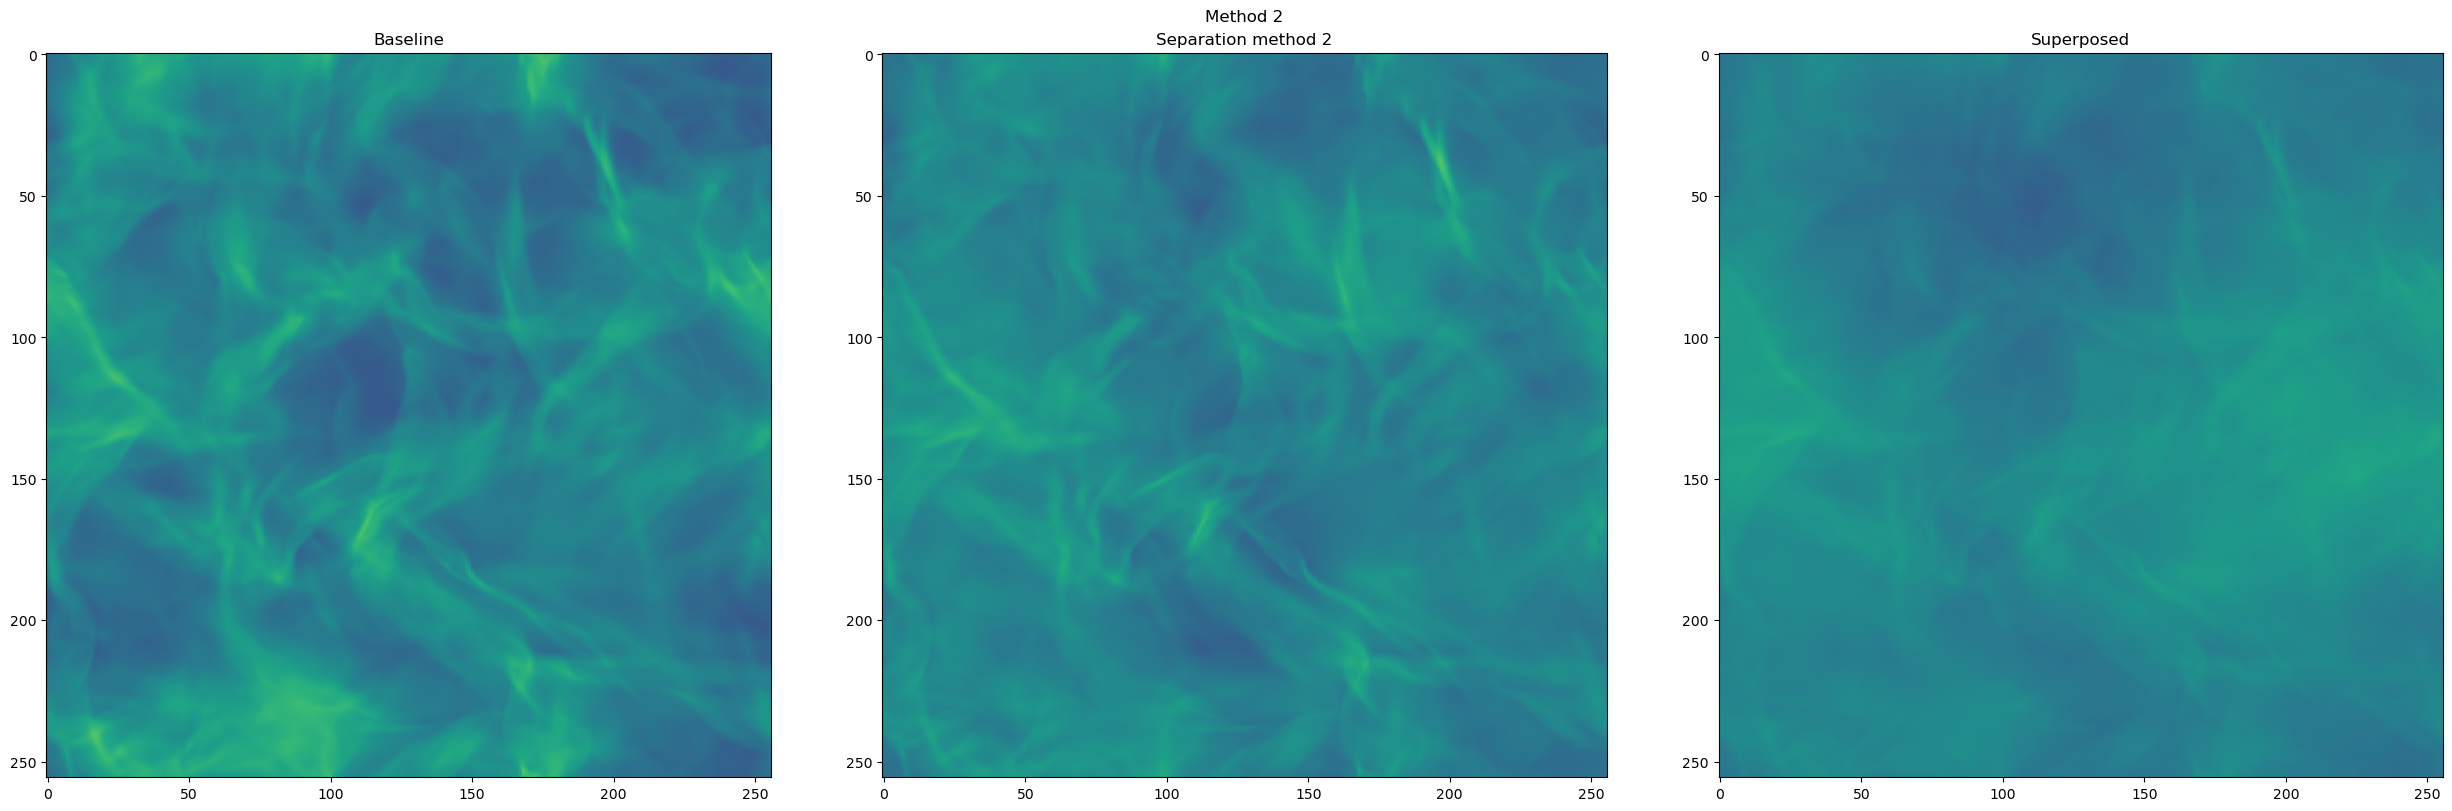

In [259]:
fig, ax= plt.subplots(1,3,figsize=(25,8), layout= 'constrained')
ax[0].imshow(im1[0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Baseline')

ax[1].imshow(sample1[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Separation method 2')

ax[2].imshow(superposition[0][0].detach().cpu(),vmin=3*amin, vmax=3*amax)
ax[2].title.set_text('Superposed')

fig.suptitle('Method 2')

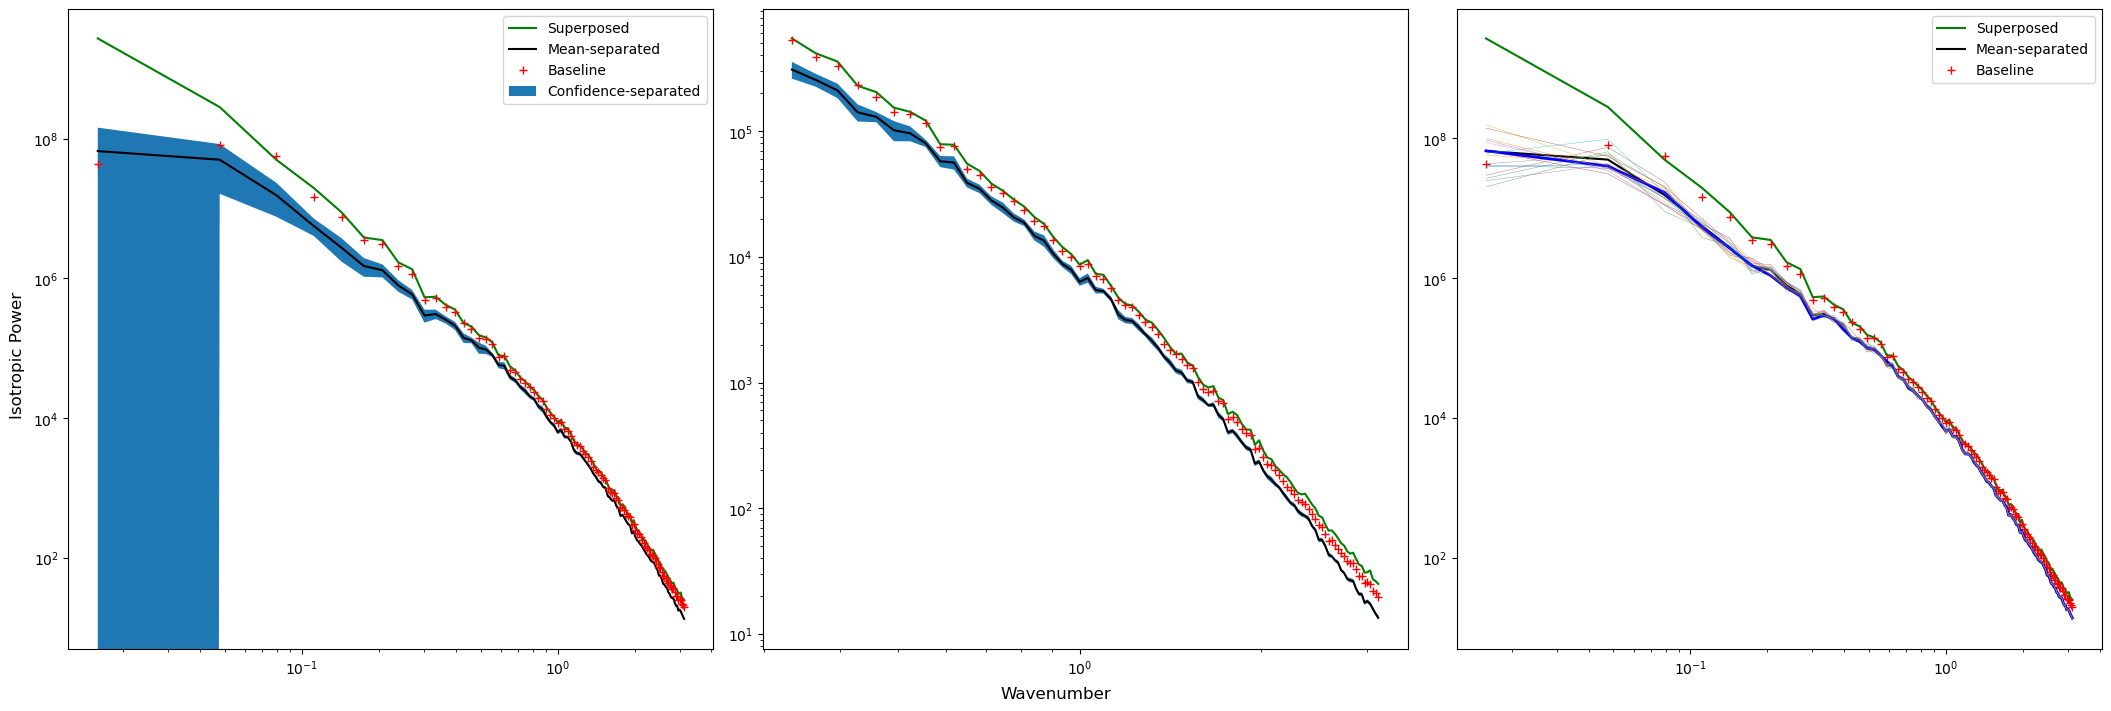

In [260]:
b0, b3, mean_, std_, bins = compare_separation_power_spectrum_iso(im1,sample1, noisy=superposition)

Text(0.5, 0.01, 'Wavenumber')

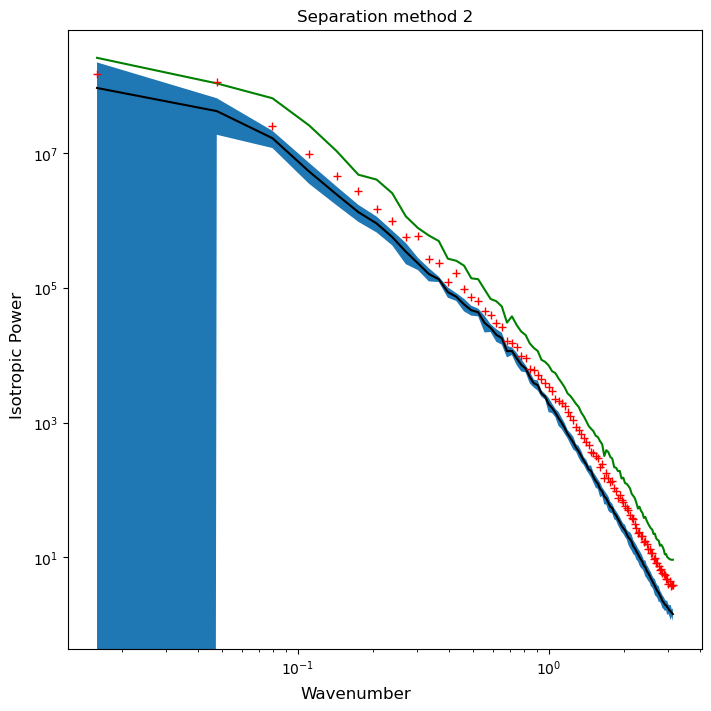

In [317]:
a,b1,c = power_spectrum_iso(sample1[0][0].detach().cpu().numpy(),bins=np.linspace(0, np.pi, 100))
_, b0, _ = power_spectrum_iso(im1[0][0],bins=a)
_, b2, _ = power_spectrum_iso(superposition[0][0].detach().cpu(), bins=a)

power_spectra1=np.concatenate([power_spectrum_iso(sample1[i][0].detach().cpu(),bins=a)[1].reshape(1,100) for i in range(8)],axis=0)
bins_centers = (a[:-1] + a[1:])/2
    
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')
mean1,std1=np.mean(power_spectra1,axis=0)[:99],np.std(power_spectra1,axis=0)[:99]

ax.plot(bins_centers,b3[:99],'g')
ax.plot(bins_centers,mean1,'-k')
ax.plot(bins_centers,b0[:99],'+r')
ax.fill_between(bins_centers,mean1+1.96*std1,mean1-1.96*std1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.title.set_text('Separation method 2')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')


Text(0.5, 0.01, 'Wavenumber')

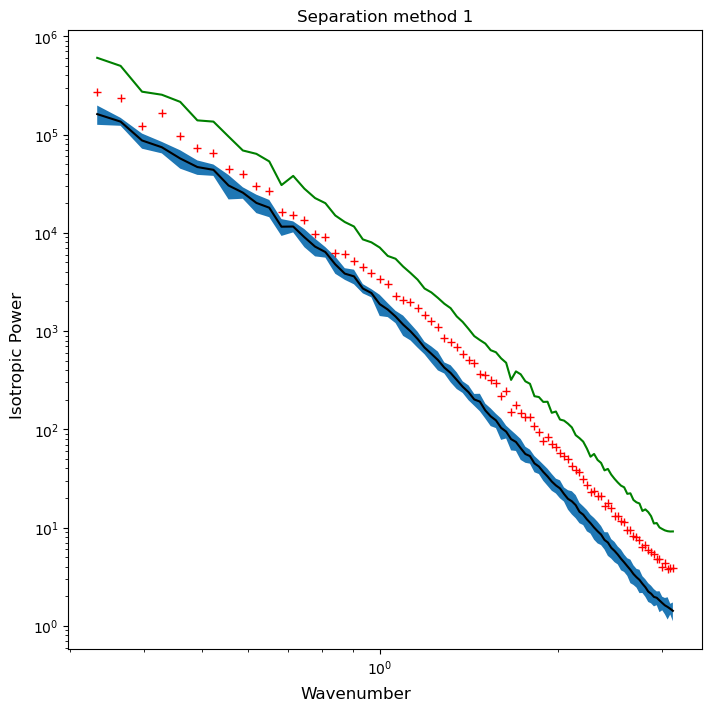

In [318]:
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')

ax.plot(bins_centers[10:],b3[10:99],'g')
ax.plot(bins_centers[10:],mean1[10:],'-k')
ax.plot(bins_centers[10:],b0[10:99],'+r')
ax.fill_between(bins_centers[10:],(mean1+1.96*std1)[10:],(mean1-1.96*std1)[10:])

ax.set_xscale('log')
ax.set_yscale('log')
ax.title.set_text('Separation method 1')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')

In [273]:
model1.eval()
model2.eval()
with torch.no_grad():
    tot_steps=model1.num_timesteps
    timesteps=list(range(tot_steps))[::-1]
    sample2=torch.randn(superpos_test.shape).to(device)

    progress_bar = tqdm(total=tot_steps)

    for t in timesteps:
        time_tensor = (torch.ones(superpos_test.shape[0], 1)* t).long().to(device)
        residual2 = model2.reverse(sample2, time_tensor)

        c_t2=model2.sqrt_alphas_cumprod[time_tensor[0]]*superpos_test

        conditional_residual2 = - model1.reverse(c_t2 - sample2, time_tensor) ## sqrt(1-alpha_barre) score y_t (c_t - x_t)

        sample2 = model2.step(residual2+conditional_residual2, time_tensor[0], sample2)
        progress_bar.update(1)


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
sample1=superpos_test-sample2

Text(0.5, 0.98, 'Method 2')

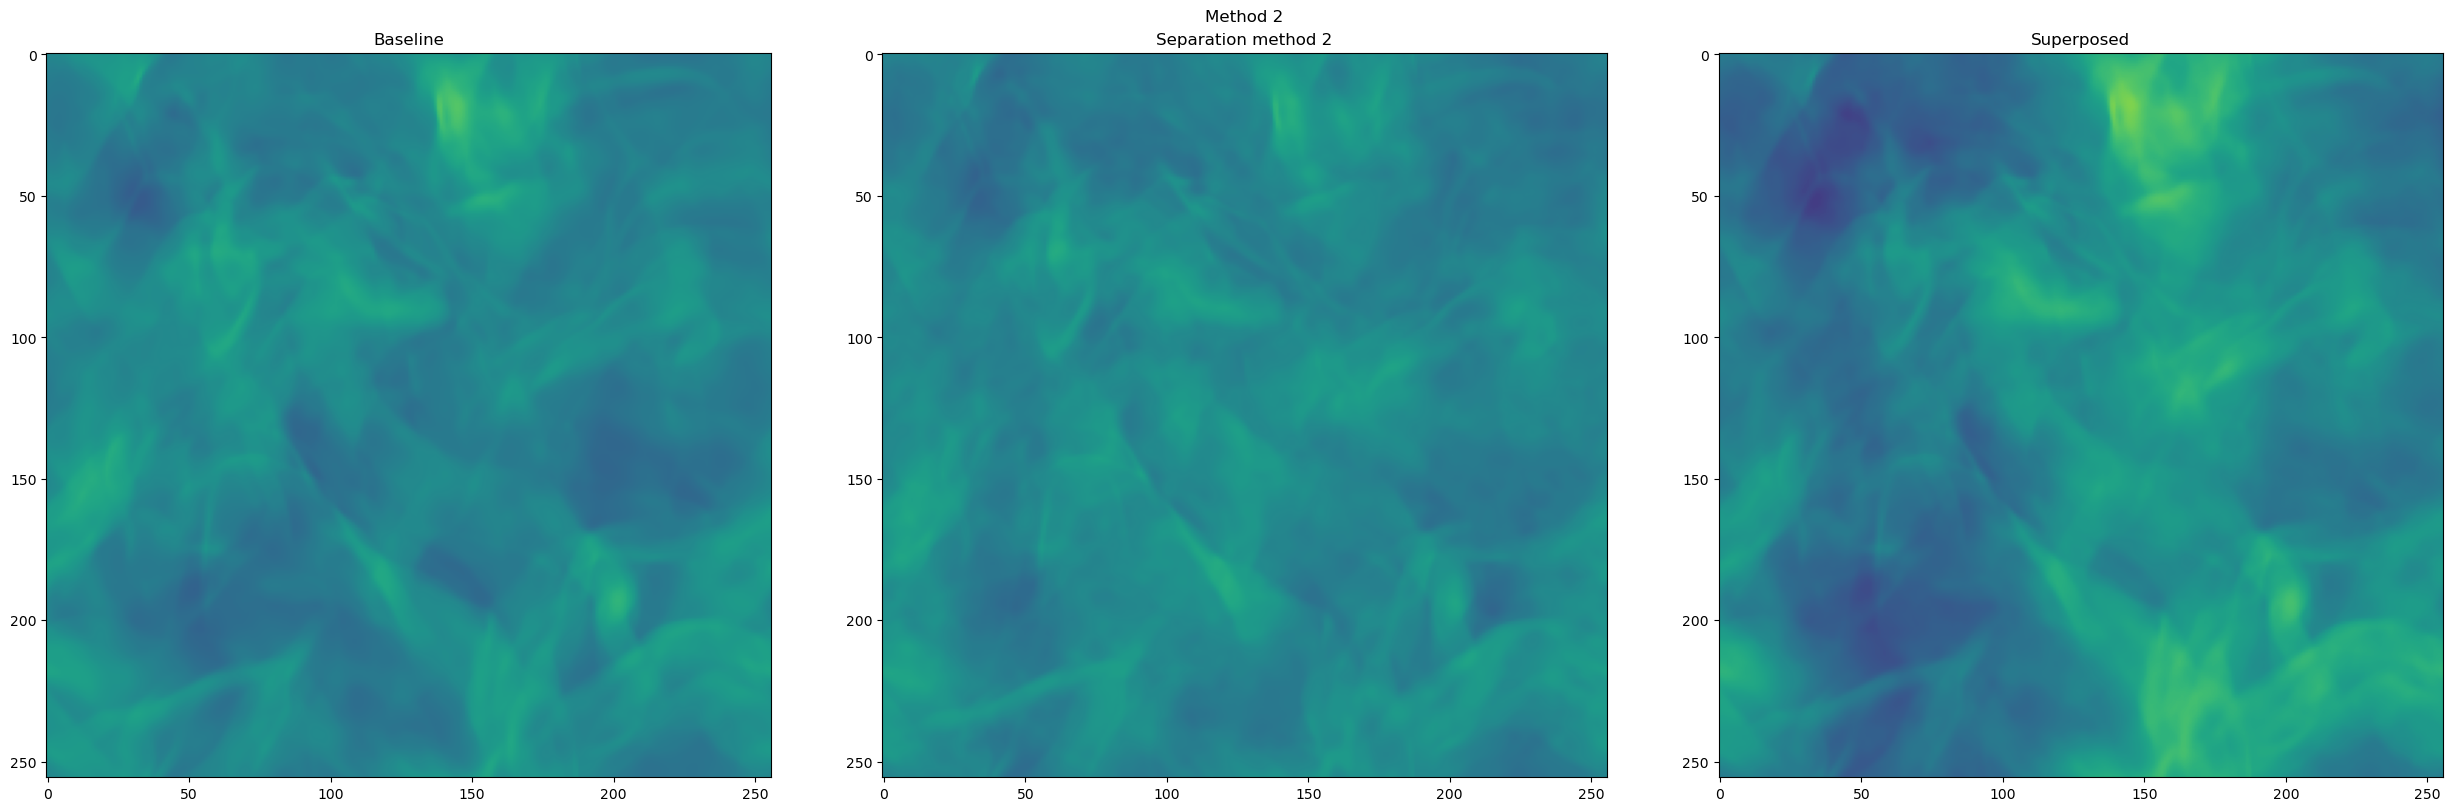

In [ ]:
fig, ax= plt.subplots(1,3,figsize=(25,8), layout= 'constrained')
ax[0].imshow(im1[0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Baseline')

ax[1].imshow(sample1[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Separation method 2')

ax[2].imshow(superposition[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[2].title.set_text('Superposed')

fig.suptitle('Method 2')

Text(0.5, 0.01, 'Wavenumber')

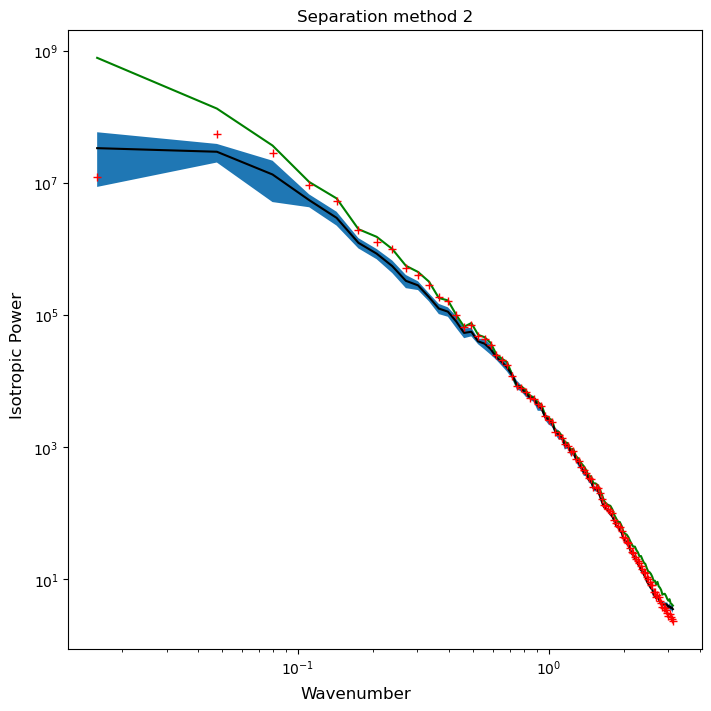

In [ ]:
a,b1,c = power_spectrum_iso(sample1[0][0].detach().cpu().numpy(),bins=np.linspace(0, np.pi, 100))
_, b0, _ = power_spectrum_iso(im1[0][0],bins=a)
_, b2, _ = power_spectrum_iso(superposition[0][0].detach().cpu(), bins=a)

power_spectra1=np.concatenate([power_spectrum_iso(sample1[i][0].detach().cpu(),bins=a)[1].reshape(1,100) for i in range(8)],axis=0)
bins_centers = (a[:-1] + a[1:])/2
    
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')
mean1,std1=np.mean(power_spectra1,axis=0)[:99],np.std(power_spectra1,axis=0)[:99]

ax.plot(bins_centers,b3[:99],'g')
ax.plot(bins_centers,mean1,'-k')
ax.plot(bins_centers,b0[:99],'+r')
ax.fill_between(bins_centers,mean1+1.96*std1,mean1-1.96*std1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.title.set_text('Separation method 2')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')



Text(0.5, 0.01, 'Wavenumber')

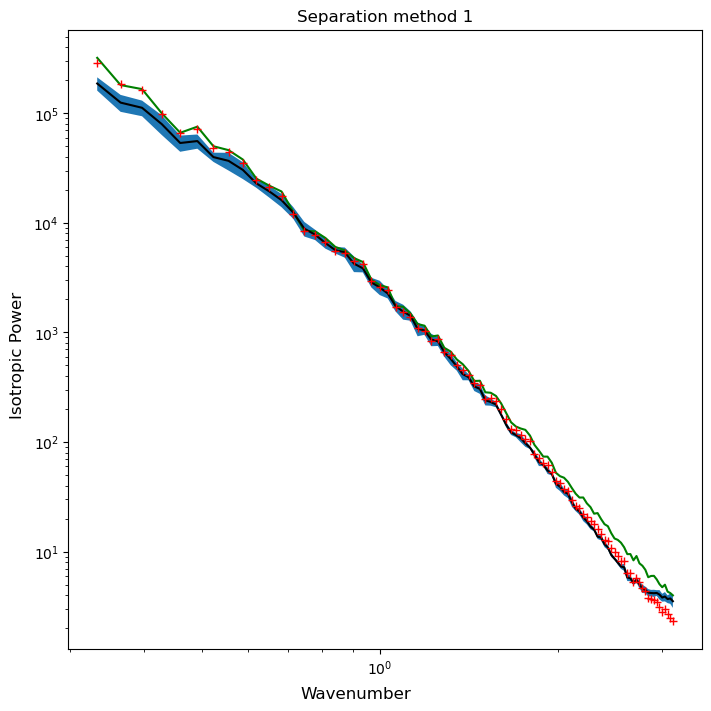

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')

ax.plot(bins_centers[10:],b3[10:99],'g')
ax.plot(bins_centers[10:],mean1[10:],'-k')
ax.plot(bins_centers[10:],b0[10:99],'+r')
ax.fill_between(bins_centers[10:],(mean1+1.96*std1)[10:],(mean1-1.96*std1)[10:])

ax.set_xscale('log')
ax.set_yscale('log')
ax.title.set_text('Separation method 1')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')

Text(0.5, 0.01, 'Wavenumber')

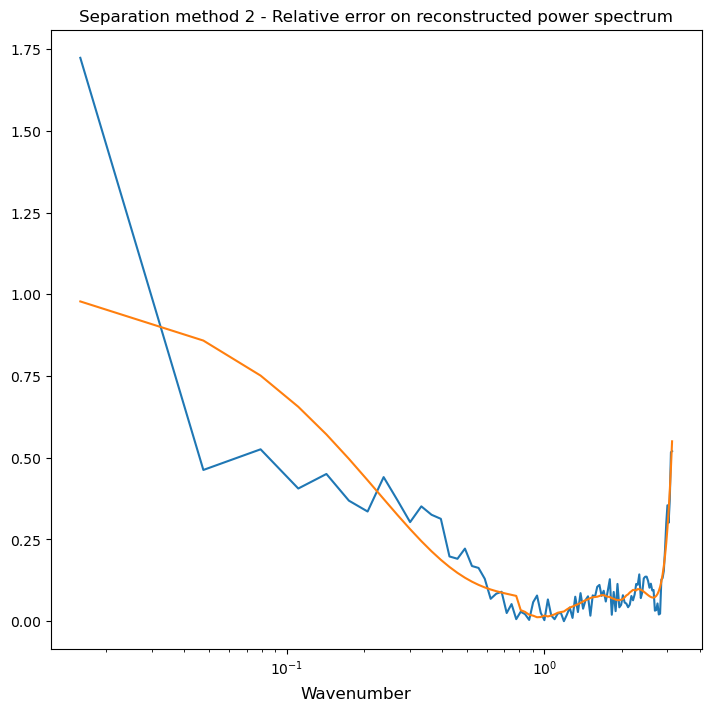

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')
ax.plot(bins_centers, np.abs(b0[:99]-mean1)/b0[:99])
ax.plot(bins_centers, savgol_filter(np.abs(b0[:99]-mean1)/b0[:99], 50, 4))
ax.set_xscale('log')
ax.title.set_text('Separation method 2 - Relative error on reconstructed power spectrum')
fig.supxlabel('Wavenumber')

In [ ]:
model1.eval()
model2.eval()
with torch.no_grad():
    tot_steps=model1.num_timesteps
    timesteps=list(range(tot_steps))[::-1]
    sample1=torch.randn(superpos_test.shape).to(device)

    progress_bar = tqdm(total=tot_steps)

    for t in timesteps:
        time_tensor = (torch.ones(superpos_test.shape[0], 1)* t).long().to(device)
        residual1 = model1.reverse(sample1, time_tensor)

        c_t1=model1.add_noise(superpos_test, torch.randn_like(superpos_test),time_tensor)

        conditional_residual1 = - model2.reverse(c_t1 - sample1, time_tensor) ## sqrt(1-alpha_barre) score y_t (c_t - x_t)

        sample1 = model1.step(residual1+conditional_residual1, time_tensor[0], sample1)
        progress_bar.update(1)

  0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 0.98, 'Method 2')

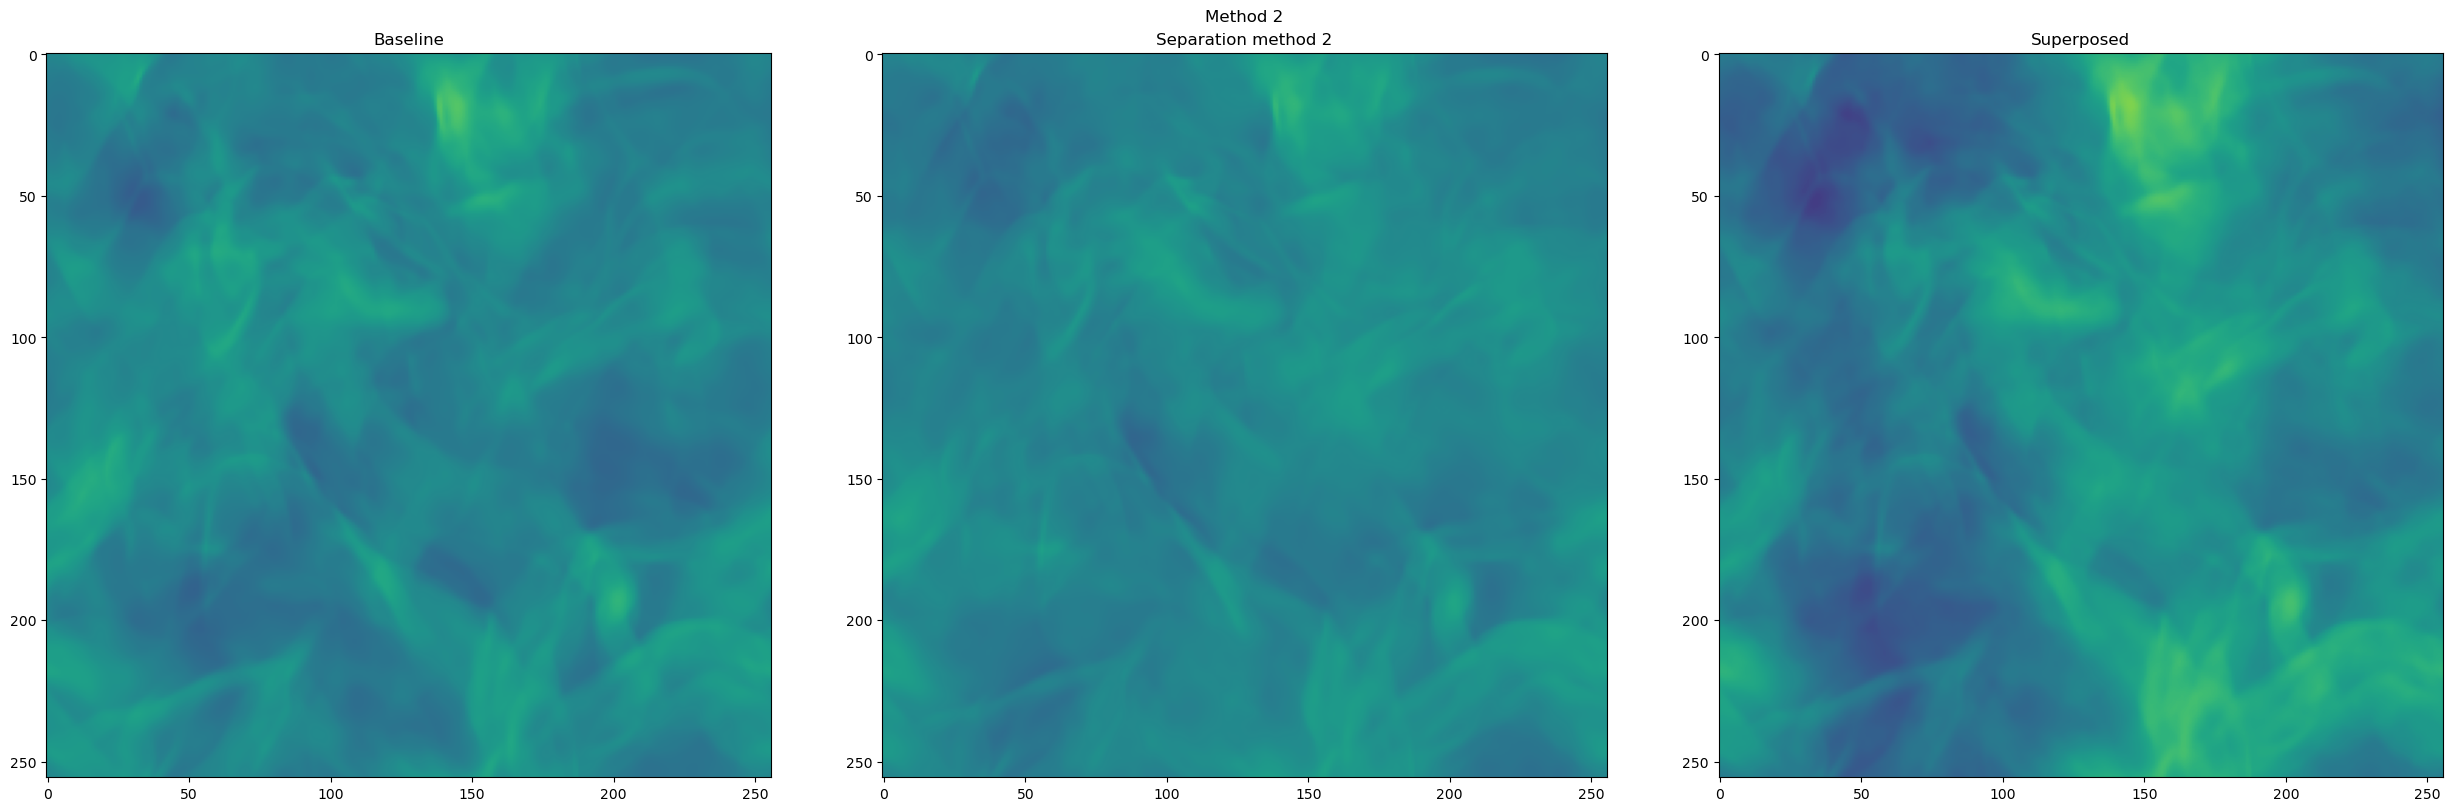

In [ ]:
fig, ax= plt.subplots(1,3,figsize=(25,8), layout= 'constrained')
ax[0].imshow(im1[0][0],vmin=amin, vmax=amax)
ax[0].title.set_text('Baseline')

ax[1].imshow(sample1[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[1].title.set_text('Separation method 2')

ax[2].imshow(superposition[0][0].detach().cpu(),vmin=amin, vmax=amax)
ax[2].title.set_text('Superposed')

fig.suptitle('Method 2')

Text(0.5, 0.01, 'Wavenumber')

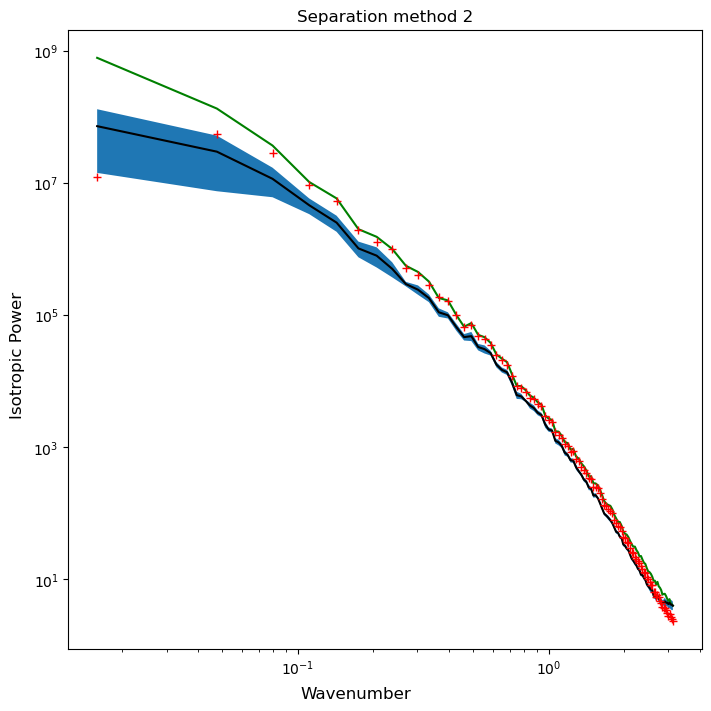

In [ ]:
a,b1,c = power_spectrum_iso(sample1[0][0].detach().cpu().numpy(),bins=np.linspace(0, np.pi, 100))
_, b0, _ = power_spectrum_iso(im1[0][0],bins=a)
_, b2, _ = power_spectrum_iso(superposition[0][0].detach().cpu(), bins=a)

power_spectra1=np.concatenate([power_spectrum_iso(sample1[i][0].detach().cpu(),bins=a)[1].reshape(1,100) for i in range(8)],axis=0)
bins_centers = (a[:-1] + a[1:])/2
    
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')
mean1,std1=np.mean(power_spectra1,axis=0)[:99],np.std(power_spectra1,axis=0)[:99]

ax.plot(bins_centers,b3[:99],'g')
ax.plot(bins_centers,mean1,'-k')
ax.plot(bins_centers,b0[:99],'+r')
ax.fill_between(bins_centers,mean1+1.96*std1,mean1-1.96*std1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.title.set_text('Separation method 2')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')

Text(0.5, 0.01, 'Wavenumber')

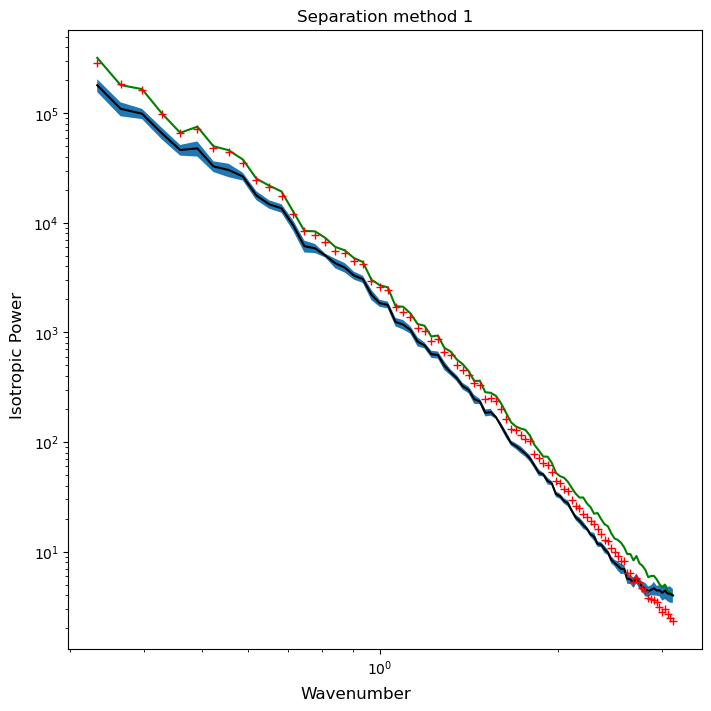

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(7,7), layout='constrained')

ax.plot(bins_centers[10:],b3[10:99],'g')
ax.plot(bins_centers[10:],mean1[10:],'-k')
ax.plot(bins_centers[10:],b0[10:99],'+r')
ax.fill_between(bins_centers[10:],(mean1+1.96*std1)[10:],(mean1-1.96*std1)[10:])

ax.set_xscale('log')
ax.set_yscale('log')
ax.title.set_text('Separation method 1')
fig.supylabel('Isotropic Power')
fig.supxlabel('Wavenumber')